# FNet

In [51]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
import re
import numpy as np

# Defining hyperparameters

VOCAB_SIZE = 2000
MAX_SAMPLES = 50000
BUFFER_SIZE = 20000
MAX_LENGTH = 300
EMBED_DIM = 256
LATENT_DIM = 512
NUM_HEADS = 8
BATCH_SIZE = 64

In [52]:
# from google.colab import drive
# drive.mount('/content/drive')

In [53]:
import os

DATA_DIR = './data/hearthstone'
# maximum_number_of_lines = 2500

def load_data(split):
    input_file = os.path.join(DATA_DIR, f'{split}_hs.in')
    output_file = os.path.join(DATA_DIR, f'{split}_hs.out')
    with open(input_file, 'r') as f:
        inputs = f.readlines()
    with open(output_file, 'r') as f:
        outputs = f.readlines()
    return inputs, outputs

train_inputs, train_outputs = load_data('train')
dev_inputs, dev_outputs = load_data('dev')
test_inputs, test_outputs = load_data('test')

train_dataset = tf.data.Dataset.from_tensor_slices((train_inputs, train_outputs))
dev_dataset = tf.data.Dataset.from_tensor_slices((dev_inputs, dev_outputs))
test_dataset = tf.data.Dataset.from_tensor_slices((test_inputs, test_outputs))

In [54]:
# next(train_dataset.batch(1_000).as_numpy_iterator())

In [55]:
def preprocess_text(sentence):
    sentence = tf.strings.lower(sentence)
    # Adding a space between the punctuation and the last word to allow better tokenization
#     sentence = tf.strings.regex_replace(sentence, r"([?.!,])", r" \1 ")
    # Replacing multiple continuous spaces with a single space
#     sentence = tf.strings.regex_replace(sentence, r"\s\s+", " ")
    # Replacing non english words with spaces
#     sentence = tf.strings.regex_replace(sentence, r"[^a-z?.!,]+", " ")
#     sentence = tf.strings.strip(sentence)
    sentence = tf.strings.join(["[start]", sentence, "[end]"], separator=" ")
    return sentence


vectorizer = layers.TextVectorization(
    VOCAB_SIZE,
    standardize=preprocess_text,
    output_mode="int",
    output_sequence_length=MAX_LENGTH,
)

# Adapt the vectorizer to the dataset
vectorizer.adapt(train_dataset.map(lambda x, y: x)) # assuming train_dataset contains only inputs

In [56]:
def vectorize_text(inputs, outputs):
    inputs, outputs = vectorizer(inputs), vectorizer(outputs)
    # One extra padding token to the right to match the output shape
    outputs = tf.pad(outputs, [[0, 1]])
    return (
        {"encoder_inputs": inputs, "decoder_inputs": outputs[:-1]},
        {"outputs": outputs[1:]},
    )


train_dataset = train_dataset.map(vectorize_text, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = dev_dataset.map(vectorize_text, num_parallel_calls=tf.data.AUTOTUNE)

train_dataset = (
    train_dataset.cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)
val_dataset = val_dataset.cache().batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [57]:
for el in train_dataset:
    print(el)
    break

({'encoder_inputs': <tf.Tensor: shape=(64, 300), dtype=int64, numpy=
array([[  12,  152,  230, ...,    0,    0,    0],
       [  12,  322,  797, ...,    0,    0,    0],
       [  12,  485,  539, ...,    0,    0,    0],
       ...,
       [  12, 1009,  202, ...,    0,    0,    0],
       [  12,  391,  536, ...,    0,    0,    0],
       [  12,  394,  404, ...,    0,    0,    0]], dtype=int64)>, 'decoder_inputs': <tf.Tensor: shape=(64, 300), dtype=int64, numpy=
array([[12,  1,  1, ...,  0,  0,  0],
       [12,  1,  1, ...,  0,  0,  0],
       [12,  1,  1, ...,  0,  0,  0],
       ...,
       [12,  1,  1, ...,  0,  0,  0],
       [12,  1,  1, ...,  0,  0,  0],
       [12,  1,  1, ...,  0,  0,  0]], dtype=int64)>}, {'outputs': <tf.Tensor: shape=(64, 300), dtype=int64, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int64)>

Test with new dataloader

In [58]:
input_path = './data/hearthstone/train_hs.in'
output_path = './data/hearthstone/train_hs.out'
full_data_path = './data/hearthstone/card_data_hs.txt'
# '/home/usman/Desktop/ml_fp/data/hearthstone/train_hs.in'

In [59]:
import numpy as np
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

maximum_number_of_lines = 1000

# load input and target files
with open(input_path, 'r') as f:
    input_lines = f.readlines()[:maximum_number_of_lines]
with open(output_path, 'r') as f:
    target_lines = f.readlines()[:maximum_number_of_lines]

# define max input and output lengths
max_input_length = 300
max_output_length = 300

# tokenize input and target sequences
text_tokenizer = Tokenizer()

text_tokenizer.fit_on_texts(input_lines + target_lines)
start_token = '<START>'
end_token = '<END>'
text_tokenizer.word_counts[start_token] = 0
text_tokenizer.word_counts[end_token] = 0
text_tokenizer.index_word[0] = end_token
# text_tokenizer.index_word[0] = start_token

input_sequences = text_tokenizer.texts_to_sequences(input_lines)
# input_vocab_size = len(text_tokenizer.word_index) + 1

target_sequences = text_tokenizer.texts_to_sequences(target_lines)
target_vocab_size = len(text_tokenizer.word_index) + 1

# pad input and target sequences
input_sequences = pad_sequences(input_sequences, maxlen=max_input_length, padding='post', truncating='post')
target_sequences = pad_sequences(target_sequences, maxlen=max_output_length, padding='post', truncating='post')

# split data into training and validation sets
input_train, input_val, target_train, target_val = train_test_split(input_sequences, target_sequences, test_size=0.2, random_state=42)

# create decoder input and target sequences
decoder_input_train = np.zeros((target_train.shape[0], max_output_length))
decoder_input_train[:, 1:] = target_train[:, :-1]

decoder_input_val = np.zeros((target_val.shape[0], max_output_length))
decoder_input_val[:, 1:] = target_val[:, :-1]

decoder_target_train = np.zeros((target_train.shape[0], max_output_length, target_vocab_size))
for i, sequence in enumerate(target_train):
    for j, index in enumerate(sequence):
        if j > 0:
            decoder_target_train[i, j - 1, index] = 1

            
VOCAB_SIZE = len(text_tokenizer.word_index) + 1

# decoder_target_val = np.zeros((target_val.shape[0], max_output_length, target_vocab_size))
# for i, sequence in enumerate(target_val):
#     for j, index in enumerate(sequence):
#         if j > 0:
#             decoder_target_val[i, j - 1, index] = 1

In [60]:
class FNetEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.dense_proj = keras.Sequential(
            [
                layers.Dense(dense_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs):
        # Casting the inputs to complex64
        inp_complex = tf.cast(inputs, tf.complex64)
        # Projecting the inputs to the frequency domain using FFT2D and
        # extracting the real part of the output
        fft = tf.math.real(tf.signal.fft2d(inp_complex))
        proj_input = self.layernorm_1(inputs + fft)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

In [61]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)


class FNetDecoder(layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [
                layers.Dense(latent_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs, value=inputs, key=inputs, attention_mask=causal_mask
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        proj_output = self.dense_proj(out_2)
        return self.layernorm_3(out_2 + proj_output)

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        return tf.tile(mask, mult)


def create_model():
    encoder_inputs = keras.Input(shape=(None,), dtype="int32", name="encoder_inputs")
    x = PositionalEmbedding(MAX_LENGTH, VOCAB_SIZE, EMBED_DIM)(encoder_inputs)
    encoder_outputs = FNetEncoder(EMBED_DIM, LATENT_DIM)(x)
    encoder = keras.Model(encoder_inputs, encoder_outputs)
    decoder_inputs = keras.Input(shape=(None,), dtype="int32", name="decoder_inputs")
    encoded_seq_inputs = keras.Input(
        shape=(None, EMBED_DIM), name="decoder_state_inputs"
    )
    x = PositionalEmbedding(MAX_LENGTH, VOCAB_SIZE, EMBED_DIM)(decoder_inputs)
    x = FNetDecoder(EMBED_DIM, LATENT_DIM, NUM_HEADS)(x, encoded_seq_inputs)
    x = layers.Dropout(0.5)(x)
    decoder_outputs = layers.Dense(VOCAB_SIZE, activation="softmax")(x)
    decoder = keras.Model(
        [decoder_inputs, encoded_seq_inputs], decoder_outputs, name="outputs"
    )
    decoder_outputs = decoder([decoder_inputs, encoder_outputs])
    fnet = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs, name="fnet")
    return fnet

In [62]:
fnet = create_model()
opt = keras.optimizers.Adam(learning_rate=0.0001)
fnet.compile(opt, loss="categorical_crossentropy", metrics=["accuracy"])

In [63]:
from keras import optimizers
from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')

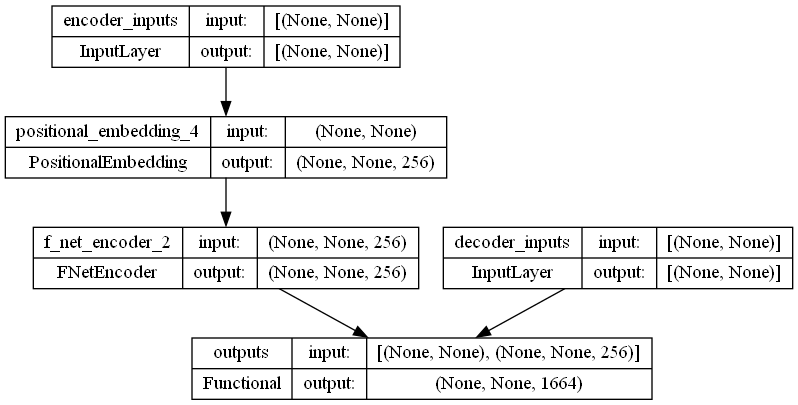

In [64]:
tf.keras.utils.plot_model(fnet, show_shapes=True, 
    show_dtype=False,
    show_layer_names=True)

In [65]:
# fnet.fit(train_dataset, epochs=3, validation_data=val_dataset, callbacks=[early_stop])
fnet.fit([input_train, decoder_input_train], decoder_target_train, validation_split=0.2, epochs=50, callbacks=[early_stop])

Epoch 1/50
11/11 [==============================] - 38s 3s/step - loss: 1.1498 - accuracy: 0.0398 - val_loss: 0.9790 - val_accuracy: 0.1294
Epoch 2/50
11/11 [==============================] - 35s 3s/step - loss: 0.9793 - accuracy: 0.1163 - val_loss: 0.8789 - val_accuracy: 0.1045
Epoch 3/50
11/11 [==============================] - 35s 3s/step - loss: 0.8978 - accuracy: 0.1336 - val_loss: 0.8105 - val_accuracy: 0.1462
Epoch 4/50
11/11 [==============================] - 35s 3s/step - loss: 0.8295 - accuracy: 0.1880 - val_loss: 0.7451 - val_accuracy: 0.2371
Epoch 5/50
11/11 [==============================] - 36s 3s/step - loss: 0.7666 - accuracy: 0.2422 - val_loss: 0.6870 - val_accuracy: 0.3118
Epoch 6/50
11/11 [==============================] - 35s 3s/step - loss: 0.7106 - accuracy: 0.3014 - val_loss: 0.6354 - val_accuracy: 0.3845
Epoch 7/50
11/11 [==============================] - 36s 3s/step - loss: 0.6617 - accuracy: 0.3466 - val_loss: 0.5928 - val_accuracy: 0.4021
Epoch 8/50
11/11 [==

In [66]:
fnet.save('./models/fnet_hs')

INFO:tensorflow:Assets written to: ./models/fnet_hs\assets


INFO:tensorflow:Assets written to: ./models/fnet_hs\assets
C:\Users\albus\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\functional.py:1563: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Users\albus\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\saving\saved_model\layer_serialization.py:134: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [67]:
text_tokenizer.word_index['super']
text_tokenizer.index_word

{1: 'end',
 2: 'в§',
 3: 'minion',
 4: 'player',
 5: 'def',
 6: '1',
 7: 'self',
 8: 'class',
 9: 'init',
 10: 'rarity',
 11: 'type',
 12: '2',
 13: 'super',
 14: 'card',
 15: 'в§в§',
 16: 'b',
 17: 'character',
 18: '3',
 19: 'cost',
 20: 'name',
 21: 'atk',
 22: 'dur',
 23: 'cls',
 24: 'race',
 25: 'game',
 26: 'nil',
 27: 'common',
 28: '4',
 29: 'target',
 30: 'return',
 31: 'spell',
 32: 'create',
 33: 'use',
 34: 'minioncard',
 35: '5',
 36: 'damage',
 37: 'battlecry',
 38: 'all',
 39: 'a',
 40: 'neutral',
 41: 'rare',
 42: 'minions',
 43: 'spellcard',
 44: '0',
 45: '6',
 46: 'your',
 47: 'attack',
 48: 'give',
 49: 'of',
 50: 'to',
 51: 'legendary',
 52: 'hearthbreaker',
 53: 'beast',
 54: '7',
 55: 'the',
 56: 'epic',
 57: 'buff',
 58: 'deathrattle',
 59: 'druid',
 60: 'summon',
 61: 'effect',
 62: 'targeting',
 63: 'find',
 64: 'actiontag',
 65: 'free',
 66: 'mech',
 67: 'and',
 68: 'deal',
 69: 'func',
 70: '8',
 71: 'health',
 72: 'playerselector',
 73: 'effects',
 74: 'if'

In [68]:
VOCAB = vectorizer.get_vocabulary()

def decode_sentence(input_sentence):
    # Mapping the input sentence to tokens and adding start and end tokens
    tokenized_input_sentence = vectorizer(
#         tf.constant("[start] " + preprocess_text(input_sentence) + " [end]")
        tf.constant(start_token + ' ' + preprocess_text(input_sentence) + ' ' + end_token)
    )
    # Initializing the initial sentence consisting of only the start token.
#     tokenized_target_sentence = tf.expand_dims(VOCAB.index("[start]"), 0)
    tokenized_target_sentence = tf.expand_dims(0, 0)


    decoded_sentence = ""

    for i in range(MAX_LENGTH):
        # Get the predictions
        predictions = fnet.predict(
            {
                "encoder_inputs": tf.expand_dims(tokenized_input_sentence, 0),
                "decoder_inputs": tf.expand_dims(
                    tf.pad(
                        tokenized_target_sentence,
                        [[0, MAX_LENGTH - tf.shape(tokenized_target_sentence)[0]]],
                    ),
                    0,
                ),
            }
        )
        # Calculating the token with maximum probability and getting the corresponding word
        sampled_token_index = tf.argmax(predictions[0, i, :])
#         sampled_token_index = tf.argmax(predictions)
#         sampled_token = VOCAB[sampled_token_index.numpy()]
        sampled_token = text_tokenizer.index_word[sampled_token_index.numpy()]
        
#         print('argmax', tf.argmax(predictions[0, i, :]))        
#         print('sampled_token_index', sampled_token_index.numpy(), 'sampled_token', sampled_token)
        
#         return predictionsW
        
        # If sampled token is the end token then stop generating and return the sentence
#         if tf.equal(sampled_token_index, VOCAB.index("[end]")) or len(decoded_sentence) > 20:
        if len(decoded_sentence) > 300:
            break
        decoded_sentence += sampled_token + " "
#         print(decoded_sentence)
        tokenized_target_sentence = tf.concat(
            [tokenized_target_sentence, [sampled_token_index]], 0
        )

    return decoded_sentence

In [69]:
pred = decode_sentence('Animal Companion NAME_END -1 ATK_END -1 DEF_END 3 COST_END -1 DUR_END Spell TYPE_END Hunter PLAYER_CLS_END NIL RACE_END Common RARITY_END Summon a random Beast Companion.')

1/1 [==============================] - 0s 61ms/step


In [70]:
pred

'в§ init в§ init init self в§ init в§ init 3 class card character all rarity rarity в§в§ create self в§ minion beast в§ <END> def minion 4 <END> def minion в§ <END> в§ <END> def minion player return 2 <END> в§ <END> в§ <END> в§ <END> в§ <END> в§ <END> в§ <END> в§ <END> в§ <END> в§ <END> в§ <END> в§ <END> '

In [71]:
text_tokenizer

In [72]:
# VOCAB[tf.argmax(pred[0, 100, :]).numpy()]

In [73]:
VOCAB

['',
 '[UNK]',
 '-1',
 'type_end',
 'rarity_end',
 'race_end',
 'player_cls_end',
 'name_end',
 'dur_end',
 'def_end',
 'cost_end',
 'atk_end',
 '[start]',
 '[end]',
 'nil',
 'minion',
 '2',
 'a',
 '3',
 'neutral',
 '1',
 'common',
 '4',
 'spell',
 'your',
 '5',
 'to',
 'rare',
 'of',
 'deal',
 'the',
 'damage',
 '<b>battlecry:</b>',
 '6',
 'give',
 'legendary',
 '7',
 'epic',
 'beast',
 'this',
 'summon',
 'druid',
 'free',
 'and',
 'all',
 '0',
 'whenever',
 '8',
 'enemy',
 'mech',
 'gain',
 'random',
 'friendly',
 'attack',
 'hunter',
 'shaman',
 'you',
 'at',
 'minion.',
 'draw',
 'attack.',
 'mage',
 'destroy',
 'each',
 'warrior',
 'warlock',
 'turn,',
 'rogue',
 'paladin',
 'priest',
 'minions',
 'hand.',
 '<b>deathrattle:</b>',
 'if',
 'card.',
 'restore',
 'health',
 'damage.',
 'or',
 'have',
 '+1',
 'weapon',
 'turn.',
 'minions.',
 'end',
 '9',
 'it',
 'health.',
 '<b>taunt</b>',
 'other',
 'nl',
 'dragon',
 'with',
 'for',
 '<b>taunt</b>.',
 'hero.',
 'an',
 'murloc',
 'he

In [74]:
'RARITY'.lower() in VOCAB

False

In [75]:
print(test_outputs[0])
print()
print(test_inputs[1])
print()
print(test_inputs[2])
print()
print(train_inputs[2])

class Archmage(MinionCard):В§    def __init__(self):В§        super().__init__("Archmage", 6, CHARACTER_CLASS.ALL, CARD_RARITY.COMMON)В§В§    def create_minion(self, player):В§        return Minion(4, 7, spell_damage=1)В§


Booty Bay Bodyguard NAME_END 5 ATK_END 4 DEF_END 5 COST_END -1 DUR_END Minion TYPE_END Neutral PLAYER_CLS_END NIL RACE_END Common RARITY_END <b>Taunt</b>


Darkscale Healer NAME_END 4 ATK_END 5 DEF_END 5 COST_END -1 DUR_END Minion TYPE_END Neutral PLAYER_CLS_END NIL RACE_END Common RARITY_END <b>Battlecry:</b> Restore 2 Health to all friendly characters.


Animal Companion NAME_END -1 ATK_END -1 DEF_END 3 COST_END -1 DUR_END Spell TYPE_END Hunter PLAYER_CLS_END NIL RACE_END Common RARITY_END Summon a random Beast Companion.



In [76]:
for i in range(2):
    print(decode_sentence(test_inputs[i]))

1/1 [==============================] - 0s 59ms/step
в§ init в§ init init self в§ init в§ init 1 class card character all rarity rarity в§в§ create self в§ character all rarity в§в§ create self в§ <END> def minion player в§ <END> в§ <END> def minion player return 2 в§ <END> в§ <END> в§ <END> в§ <END> в§ <END> в§ <END> в§ <END> в§ <END> в§ <END> в§ <END> 
1/1 [==============================] - 0s 61ms/step
в§ init в§ init init self в§ init в§ init 2 class card character all rarity rarity в§в§ create self в§ hearthbreaker find spell в§в§ create self в§ <END> def minion player в§ <END> в§ <END> def minion player return 2 в§ <END> в§ <END> в§ <END> в§ <END> в§ <END> в§ <END> в§ <END> в§ <END> в§ <END> в§ 


## Evaluation

In [86]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras

import nltk
import numpy as np
from nltk.translate.bleu_score import sentence_bleu
from sklearn.metrics import accuracy_score

In [87]:
bleu_scores_fnet = []
for i in range(len(test_inputs)):
    decoded_sentence = decode_sentence(test_inputs[i])
    bleu_score = sentence_bleu([test_outputs[i]], decoded_sentence)
    bleu_scores_fnet.append(bleu_score)
bleu_scores_fnet = np.round(np.mean(bleu_scores_fnet), 2)

1/1 [==============================] - 0s 60ms/step


1/1 [==============================] - 0s 64ms/step


1/1 [==============================] - 0s 63ms/step


1/1 [==============================] - 0s 67ms/step


1/1 [==============================] - 0s 64ms/step


1/1 [==============================] - 0s 66ms/step


1/1 [==============================] - 0s 65ms/step


1/1 [==============================] - 0s 68ms/step


1/1 [==============================] - 0s 70ms/step


1/1 [==============================] - 0s 65ms/step


1/1 [==============================] - 0s 67ms/step


1/1 [==============================] - 0s 73ms/step


1/1 [==============================] - 0s 69ms/step


1/1 [==============================] - 0s 74ms/step


1/1 [==============================] - 0s 74ms/step


1/1 [==============================] - 0s 77ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 75ms/step


1/1 [==============================] - 0s 87ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 77ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 87ms/step


1/1 [==============================] - 0s 86ms/step


1/1 [==============================] - 0s 91ms/step


1/1 [==============================] - 0s 92ms/step


In [88]:
print(bleu_scores_fnet)

0.17


In [89]:
test_outputs

['class Archmage(MinionCard):В§    def __init__(self):В§        super().__init__("Archmage", 6, CHARACTER_CLASS.ALL, CARD_RARITY.COMMON)В§В§    def create_minion(self, player):В§        return Minion(4, 7, spell_damage=1)В§\n',
 'class BootyBayBodyguard(MinionCard):В§    def __init__(self):В§        super().__init__("Booty Bay Bodyguard", 5, CHARACTER_CLASS.ALL, CARD_RARITY.COMMON)В§В§    def create_minion(self, player):В§        return Minion(5, 4, taunt=True)В§\n',
 'class DarkscaleHealer(MinionCard):В§    def __init__(self):В§        super().__init__("Darkscale Healer", 5, CHARACTER_CLASS.ALL, CARD_RARITY.COMMON, battlecry=Battlecry(Heal(2), CharacterSelector()))В§В§    def create_minion(self, player):В§        return Minion(4, 5)В§\n',
 'class FieryWarAxe(WeaponCard):В§    def __init__(self):В§        super().__init__("Fiery War Axe", 2, CHARACTER_CLASS.WARRIOR, CARD_RARITY.FREE)В§В§    def create_weapon(self, player):В§        return Weapon(3, 2)В§\n',
 'class FrostwolfWarlord(Min

In [90]:
accuracy_fnet = []

for i in range(len(test_inputs)):
    decoded_sentence = decode_sentence(test_inputs[i])
    val = test_outputs[i]
    val_words = val.split()
    decoded_words = decoded_sentence.split()
    num_correct = 0
    for j in range(min(len(val_words), len(decoded_words))):
        if val_words[j] == decoded_words[j]:
            num_correct += 1
    acc_fnet = num_correct / max(len(val_words), len(decoded_words))
    accuracy_fnet.append(acc_fnet)

accuracy_fnet = np.round(np.mean(accuracy_fnet), 2)

1/1 [==============================] - 0s 109ms/step


1/1 [==============================] - 0s 109ms/step


1/1 [==============================] - 0s 120ms/step


1/1 [==============================] - 0s 115ms/step


1/1 [==============================] - 0s 140ms/step


1/1 [==============================] - 0s 116ms/step


1/1 [==============================] - 0s 103ms/step


1/1 [==============================] - 0s 115ms/step


1/1 [==============================] - 0s 123ms/step


1/1 [==============================] - 0s 132ms/step


1/1 [==============================] - 0s 119ms/step


1/1 [==============================] - 0s 138ms/step


1/1 [==============================] - 0s 122ms/step


1/1 [==============================] - 0s 125ms/step


1/1 [==============================] - 0s 142ms/step


1/1 [==============================] - 0s 158ms/step


1/1 [==============================] - 0s 163ms/step


1/1 [==============================] - 0s 172ms/step


1/1 [==============================] - 0s 164ms/step


1/1 [==============================] - 0s 181ms/step


1/1 [==============================] - 0s 169ms/step


1/1 [==============================] - 0s 182ms/step


1/1 [==============================] - 0s 183ms/step


1/1 [==============================] - 0s 198ms/step


1/1 [==============================] - 0s 274ms/step


1/1 [==============================] - 0s 192ms/step


1/1 [==============================] - 0s 235ms/step


1/1 [==============================] - 0s 205ms/step


In [97]:
print(accuracy_fnet)

0.0


### Scores

In [98]:
data = [
    ["FNet", accuracy_fnet, bleu_scores_fnet]
]
columns = ["Model", "Accuracy", "BLEU"]

In [99]:
results = pd.DataFrame(data, columns=columns)

In [100]:
results

,Model,Accuracy,BLEU
0,FNet,0.0,0.17
